In [2]:
import json

with open("/epyc/projects/kbmod/runs/DEEP/xmatch_catalogs/fitres_per_night_per_stare.json") as f:
    kbmod_results = json.load(f)

In [11]:
import astropy.table

t = []
for k in kbmod_results:
    night, target = k.split("_")
    night = int(night)
    t.append(
        {"night": night, "target": target, "block": target[0:2], **kbmod_results[k]['fit']}
    )
results = astropy.table.Table(t)

In [22]:
results

night,target,block,c,k,m_50,sigma_c,sigma_k,sigma_m_50
int64,str3,str2,float64,float64,float64,float64,float64,float64
20190402,A0b,A0,0.8891089293288719,3.1147450606863147,25.798936292052552,0.0015811517660403215,0.035078239971523206,0.004492777798896285
20190403,A0c,A0,0.9337558694755008,1.6155916626198876,25.456359434396326,0.0027025522988996433,0.018616425624865682,0.00781360056071236
20190504,A0a,A0,0.9742332101088382,1.464956446651612,25.56809650477574,0.0014485503896924756,0.010787101972476275,0.005600840421943094
20190504,A1a,A1,0.9341212556177112,1.152156530828282,24.877653450801645,0.0035964269137047635,0.011036831785538848,0.012203835417336382
20190505,A0c,A0,0.8985421614536486,1.9744399676603583,25.4607593233939,0.0027816923183235976,0.025270225015385245,0.007897090852674553
20190505,A1c,A1,0.9999999883653061,1.2663905641807855,23.9903589530269,0.002540417125171751,0.008908287148878183,0.009739954755189737
20190507,A0b,A0,0.8519156180332331,3.543953268608695,25.68682190842442,0.0018127983912136626,0.04586807229925202,0.005028723379828626
20190507,A1b,A1,0.7810973089789919,1.3768786464987521,24.419668479605733,0.005027065838113359,0.016076205655093927,0.01602956762783226
20190601,A1b,A1,0.7792400142109328,1.2540443073789387,24.34785184980791,0.005736085238979533,0.015639570021889097,0.01950003613882209


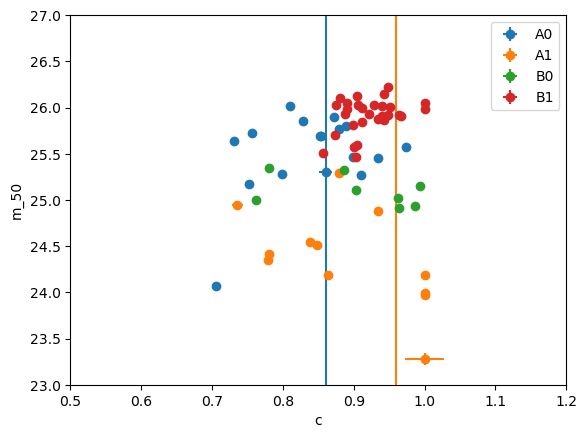

In [30]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
for g in results.group_by("block").groups:
    plt.errorbar(g['c'], g['m_50'], xerr=g['sigma_c'], yerr=g['sigma_m_50'], fmt='o', label=g[0]['block'])
plt.ylim(23, 27)
plt.xlim(0.5, 1.2)
plt.xlabel("c")
plt.ylabel("m_50")
plt.legend()
plt.show()

In [123]:
def ic(night, target):
    p = f"/epyc/projects/kbmod/data/image_collections/{night}_{target}.collection"
    t = astropy.table.Table.read(p, format='ascii.ecsv')

    exposureTime = 120.0 # seconds
    
    fiducialPsfSigma = 1.6 # pixels; 1 arcsec FWHM seeing
    f_eff = (t['psfSigma'] / fiducialPsfSigma)**-2

    fiducialZeroPoint = 25.0 # VR mag
    zeroPointDiff = fiducialZeroPoint - (t['zeroPoint'] - 2.5*np.log10(exposureTime))
    maxEffectiveTransparency = float('inf')
    c_eff = np.min(
        [10**(-2.0*(zeroPointDiff)/2.5), np.ones_like(zeroPointDiff) * maxEffectiveTransparency], axis=0
    )

    fiducialSkyBackground = 1.0 # ADU/s self.config.fiducialSkyBackground[band]
    b_eff = fiducialSkyBackground/(t['skyBg']/exposureTime)

    # Effective exposure time scale factor
    t_eff = f_eff * c_eff * b_eff

    # Effective exposure time (seconds)
    effectiveTime = t_eff * exposureTime

    # Output quantities
    t['effTime'] = effectiveTime
    t['effTimePsfSigmaScale'] = f_eff
    t['effTimeSkyBgScale'] = b_eff
    t['effTimeZeroPointScale'] = c_eff
    
    return t

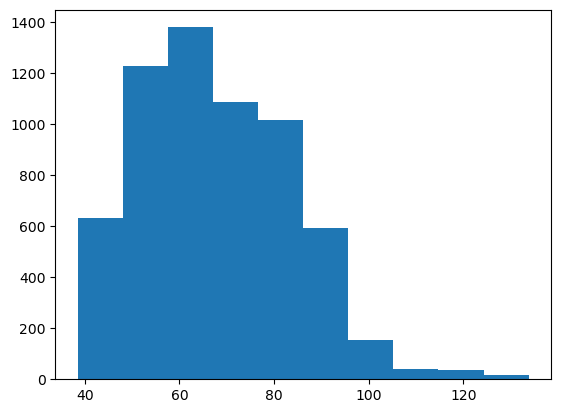

In [131]:
t = ic(results[0]['night'], results[0]['target'])
plt.hist(t['effTime'])
plt.show()
# np.median(t['psfSigma']), np.median(t['zeroPoint']), np.median(t['skyBg']), np.median(t['skyNoise'])

In [135]:
s = []
c = ['effTime', 'psfSigma', 'zeroPoint', 'skyBg', 'skyNoise']
for r in results:
    night, target = r['night'], r['target']
    t = ic(night, target)
    d = {
        "night": night,
        "target": target,
        "num_images": len(t),
        
    }
    for _ in c:
        l, m, h = np.percentile(t[_], [25, 50, 75])
        d[_] = m
        d[_ + "_sigma"] = (h - l) / 2
    
    s.append(d)
    
stats = astropy.table.Table(s)

In [136]:
joined = astropy.table.join(results, stats, keys=['night', 'target'])

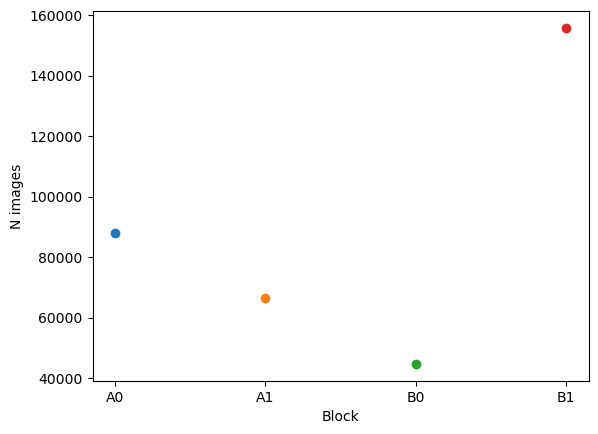

In [138]:
for g in joined.group_by("block").groups:
    plt.scatter(g[0]['block'], g['num_images'].sum())
    
plt.xlabel("Block")
plt.ylabel("N images")
plt.show()

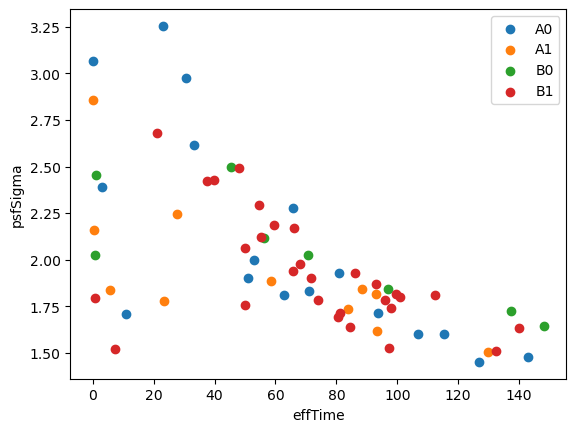

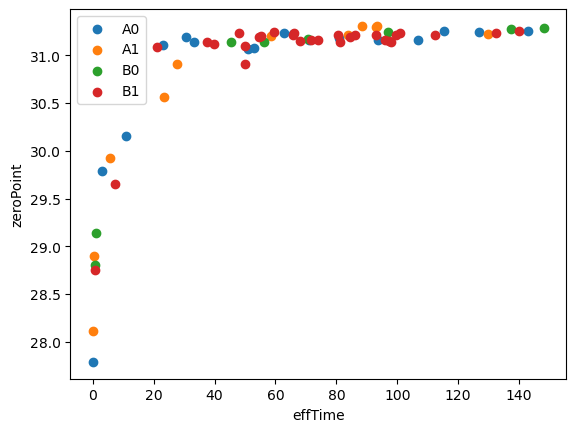

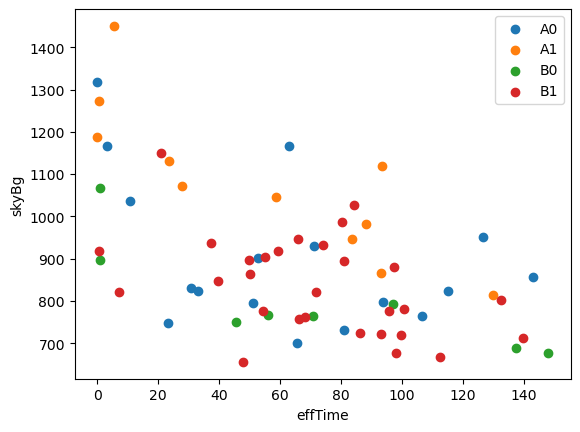

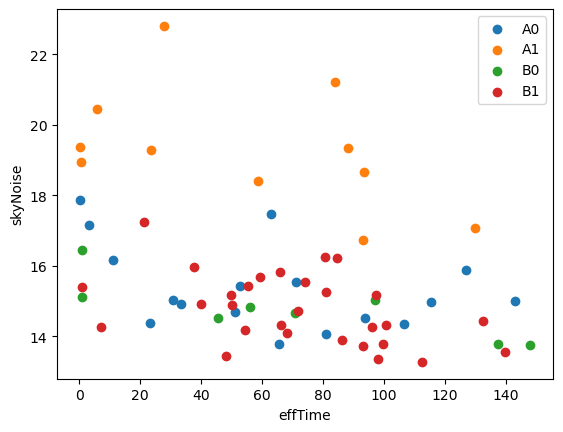

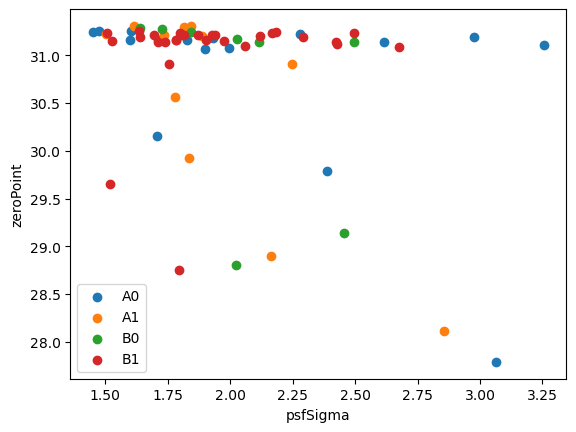

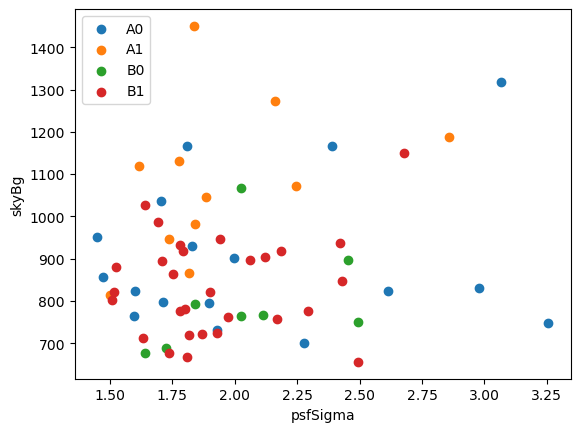

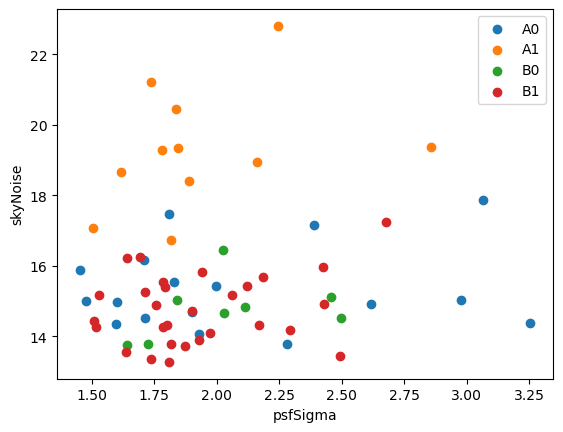

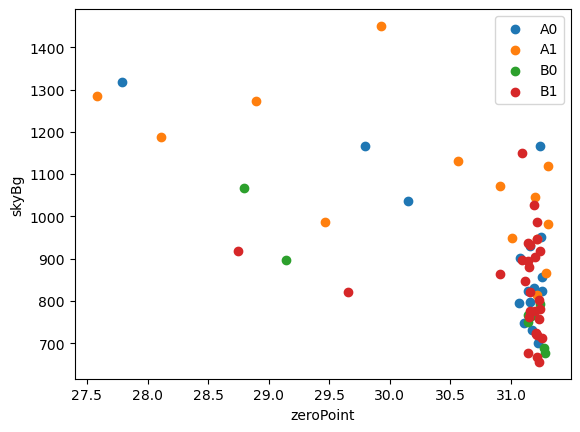

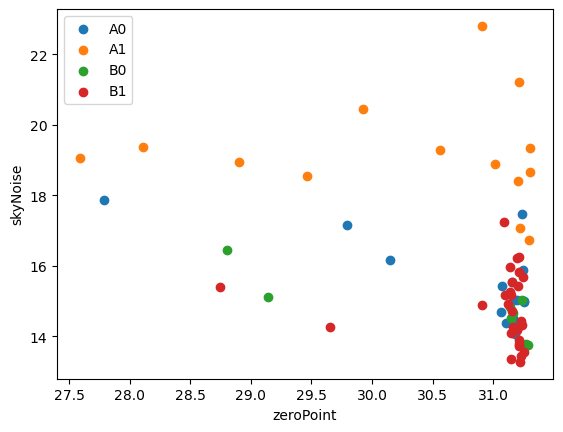

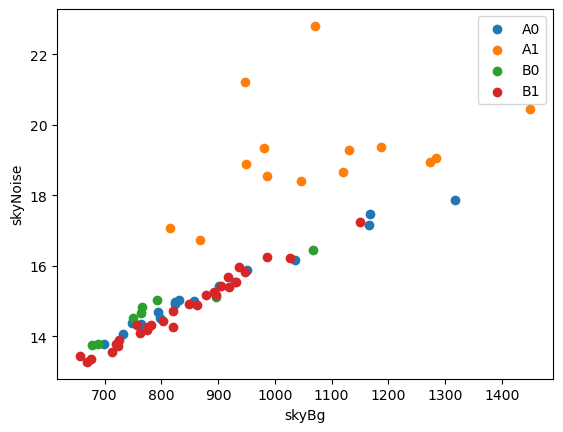

In [140]:
import itertools

c = ['effTime', 'psfSigma', 'zeroPoint', 'skyBg', 'skyNoise']
for x, y in itertools.combinations(c, 2):
    fig = plt.figure()
    for g in joined.group_by("block").groups:
        plt.scatter(g[x], g[y], label=g[0]['block'])
        
#     if y == "zeroPoint":
#         plt.ylim(30.5, 31.5)
        
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.show()

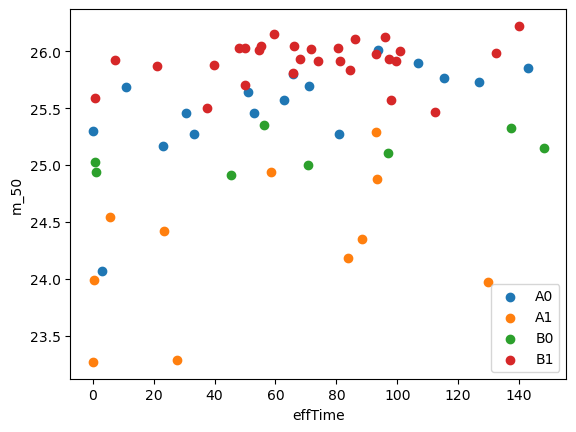

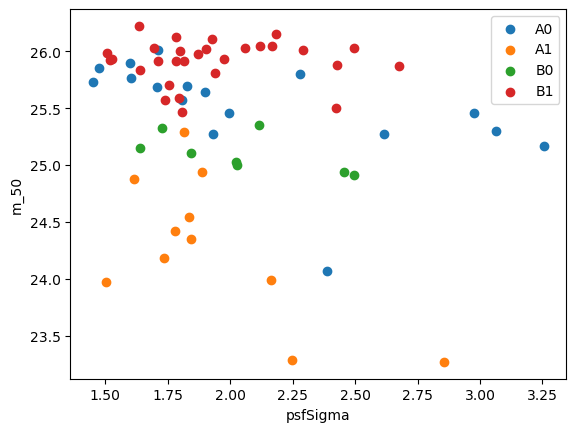

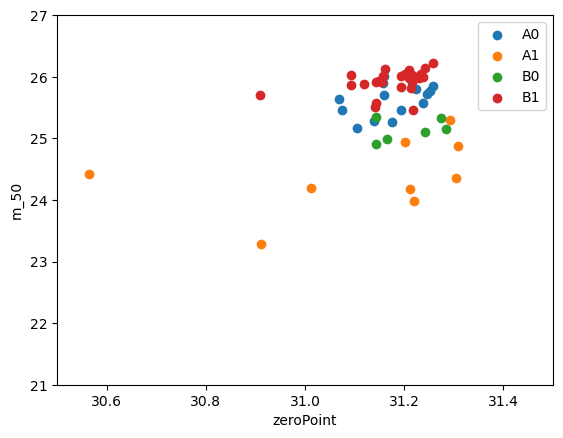

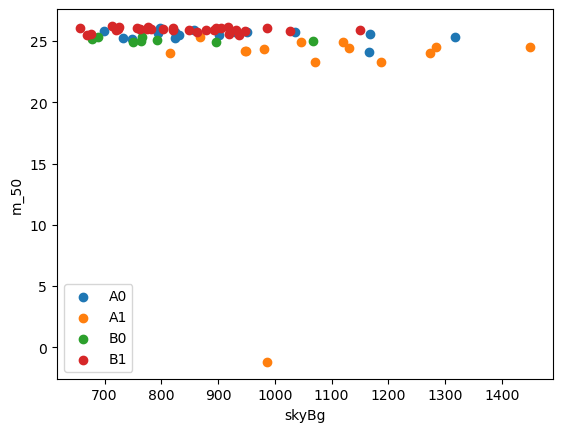

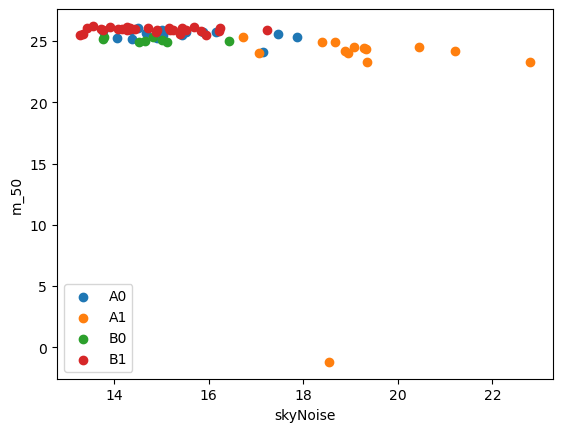

In [146]:
c = ['effTime', 'psfSigma', 'zeroPoint', 'skyBg', 'skyNoise']
for x in c:
    fig = plt.figure()
    for g in joined.group_by("block").groups:
        plt.scatter(g[x], g['m_50'], label=g[0]['block'])
        
    if x == "zeroPoint":
        plt.xlim(30.5, 31.5)
        plt.ylim(21, 27)
        
    plt.xlabel(x)
    plt.ylabel('m_50')
    plt.legend()
    plt.show()